# **semantic chunking with comparaision between sequential chunking**


In [ ]:
!pip install pymupdf
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 24.0 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Charger le modèle d'embedding
model = SentenceTransformer('all-MiniLM-L6-v2')  # Modèle léger pour des embeddings

# Lire le fichier PDF
pdf_file_path = 'rh_policy_entreprise_xxx.pdf'  # Remplacez par le chemin vers votre fichier
doc = fitz.open(pdf_file_path)

# Extraire le texte du PDF
text = ""
for page in doc:
    text += page.get_text()

# Fermer le document PDF
doc.close()

# Diviser le texte en phrases
sentences = re.split(r'(?<=[.?!])\s+', text)

# Créer des embeddings pour les phrases
embeddings = model.encode(sentences)

# Calculer les distances cosinus entre les embeddings
def calculate_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        similarity = cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        distance = 1 - similarity
        distances.append(distance)
    return distances




/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

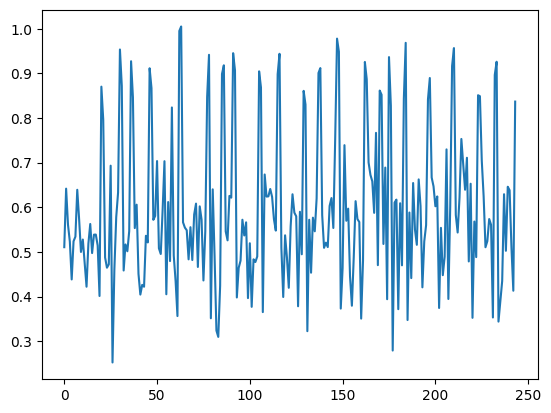

In [ ]:
import matplotlib.pyplot as plt
distances = calculate_cosine_distances(embeddings)
plt.plot(distances);

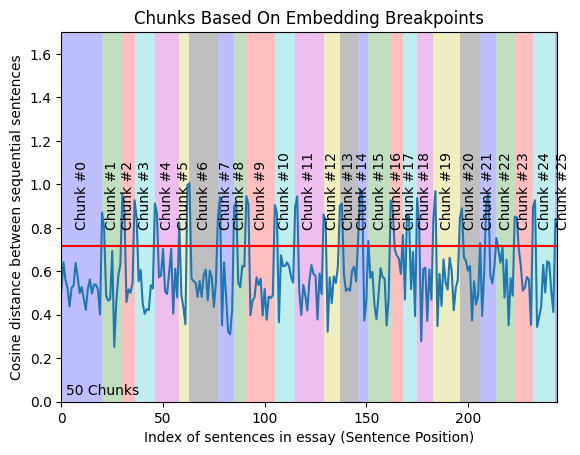

In [ ]:

plt.plot(distances);

y_upper_bound = 1.7
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))
# Déterminer le seuil pour le chunking
breakpoint_distance_threshold = np.percentile(distances, 80)
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');
# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Identifier les indices où les distances dépassent le seuil
indices_above_threshold = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]
# Filtrer les indices pour ignorer ceux qui sont trop proches les uns des autres
filtered_indices = [indices_above_threshold[0]]  # Démarrer avec le premier indice
min_distance_between_chunks = 5
for i in range(1, len(indices_above_threshold)):
    if indices_above_threshold[i] - filtered_indices[-1] >= min_distance_between_chunks:
        filtered_indices.append(indices_above_threshold[i])
# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Visualisation avec les indices filtrés
for i, breakpoint_index in enumerate(filtered_indices):
    start_index = 0 if i == 0 else filtered_indices[i - 1]
    end_index = breakpoint_index if i < len(filtered_indices) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# Ajout d'un shading pour le dernier chunk si nécessaire
if filtered_indices:
    last_breakpoint = filtered_indices[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(filtered_indices) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")

plt.show()


In [ ]:
# Regrouper les phrases en chunks en utilisant les indices filtrés
chunks = []
start_index = 0
for index in filtered_indices:
    group = sentences[start_index:index + 1]
    combined_text = ' '.join(group)
    chunks.append(combined_text)
    start_index = index + 1

# Ajouter le dernier groupe s'il reste des phrases
if start_index < len(sentences):
    combined_text = ' '.join(sentences[start_index:])
    chunks.append(combined_text)

# Afficher les chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk #{i + 1}:")
    print(chunk[:200] + "...")
    print("\n")

Chunk #1:
Introduction Générale
Introduction Générale
Présentation de l ’ent repr ise XXX
L’e ntrepris e X XX est une en trep ris e innova nte spécialis ée dans le d oma ine d
e l'automobi le, reconnue po ur so...


Chunk #2:
1. Types de Congés
l’entreprise XXX offre plusieurs types de congés afin de répondre aux besoins
divers de ses employés :
Congés Annuels :
Chaque employé à temps plein a droit à 25 jours de congés pay...


Chunk #3:
2. Procédure de Demande de Congés
La demande de congés doit être effectuée selon la procédure suivante :
Soumission de la Demande :
Les employés doivent soumettre une demande de congé par écrit à leur...


Chunk #4:
3. Accumulation et Utilisation des Congés
Accumulation des Congés :
Les jours de congés annuels non utilisés peuvent être reportés à l'année suivante,
avec un maximum de 5 jours reportables. Au-delà d...


Chunk #5:
1. Processus de Publication des Offres d'Emploi
Identification des Besoins en Recrutement :
Les responsables de départements d

# **Indexing**

In [ ]:
pip install langchain langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 60.9 MB/s eta 0:00:00

In [ ]:
from langchain import LLMChain
from langchain.llms import HuggingFaceHub
from google.colab import userdata

llm_llma = HuggingFaceHub(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    huggingfacehub_api_token=userdata.get('huggingfacehub_api_token'),
)


<ipython-input-7-8c9cc61de5f3>:5: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm_llma = HuggingFaceHub(


In [ ]:
import uuid
from langchain.llms import HuggingFaceHub  # Utilisation de HuggingFaceHub au lieu de ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_core.output_parsers import StrOutputParser
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.embeddings import HuggingFaceEmbeddings  # Remplace OpenAIEmbeddings par HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

In [ ]:
docs = [Document(page_content=chunk, metadata={"source":"politique RH"}) for chunk in chunks]
print (f"You have {len(docs)} docs")

You have 26 docs


In [ ]:
chain = load_summarize_chain(llm_llma)

In [ ]:
id_key = "doc_id" # This is the key that we will tell the retriever to connect the summaries and original docs on

summaries = [] # To hold our summaries

for doc in docs:
    # First let's get an ID that we'll assign to the chunk and summary. You don't need a UUID here, use whatever you want
    unique_id = str(uuid.uuid4())

    # Then let's get the summary
    doc_summary= chain.run([doc])
    summary_start = doc_summary.find("CONCISE SUMMARY:") + len("CONCISE SUMMARY:")
    summary = doc_summary[summary_start:].strip()
    doc_summary_document = Document(page_content=summary, metadata={id_key: unique_id}) # Give the ID to the summary
    summaries.append(doc_summary_document)

    # Then finnally add that same id to your chunk
    doc.metadata[id_key] = unique_id

print (f"You have {len(summaries)} summaries to go along with your {len(chunks)} chunks")

<ipython-input-11-a845d04a0829>:10: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  doc_summary= chain.run([doc])


You have 26 summaries to go along with your 26 chunks


In [ ]:
print(summaries[4])

page_content='The process of publishing job offers involves several steps. First, the department head identifies the need for recruitment and submits a request to the HR department. The HR department, in collaboration with the department head, creates a detailed job description, including the job title, responsibilities, qualifications, and conditions of work. The job offer is then published on various platforms, such as the company's website, social media, and job boards. The HR department receives and processes candidate applications, and then conducts a preliminary selection' metadata={'doc_id': '41091267-bc8c-40e5-b9cb-aee5da9ff0c6'}


# **retrieving**

In [ ]:
from langchain.embeddings import SentenceTransformerEmbeddings
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

<ipython-input-12-4ebf07722f11>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# The vectorstore to use to index the summary chunks
vectorstore = Chroma(collection_name="summaries",embedding_function=embeddings)

# The storage layer for the parent documents
docstore = InMemoryStore()

<ipython-input-13-ff64323779e0>:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries",embedding_function=embeddings)


In [ ]:
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

In [ ]:
# Add your summary docs (with their ids) to the vectorstore. I'm unsure why a list of a uuid is returned, might be a bug.
retriever.vectorstore.add_documents(summaries)

['dc2a2070-5124-4d53-af58-9ff851514f65',
 '18dbcb68-9c93-4aeb-a4be-c16732af1e13',
 '9e43da59-3816-4ee3-af75-855d40f06276',
 'a2117886-ae2d-4955-8eed-00339fac1f97',
 'ff3be30d-d840-4877-8891-1d3a19ad6d65',
 '4f0547d8-d938-4102-b255-0f3ec22a7107',
 'f640b97b-a7fc-445c-9c4c-b7ed9b608a73',
 '2559c8e6-7677-4643-b5c8-49668de2c2dc',
 '80933ad5-ef1c-478b-8584-571590681ed4',
 'b3e1a285-a35c-4727-9649-787a0f1e0aab',
 '987f39cf-39f2-4b60-8be2-a4b38e294f4c',
 'eff5efa3-0513-48f2-8f6d-735f67aabf46',
 '50698c0e-4341-434b-9944-2339f0d7fcdb',
 '8cc4aec5-c83f-456a-bb04-f514743ceb7f',
 '4ed78242-ad6f-4bb0-963f-973a041c3804',
 '34414465-6fad-4969-976c-81faa5afe167',
 'bd68c54b-9a1a-4213-ae0c-5cd0bf5ef659',
 '775ba93d-0ce0-479d-a03d-82f5327101f4',
 '801b13a5-b39c-461b-a8b8-bb95fdd5fb71',
 'ddcd68a0-9c5e-491f-ab95-f3109f9c0a34',
 'd9c5f6a6-027d-4d38-b160-5792596e3f13',
 '35749afa-aadc-42f1-82d0-c397fd130568',
 '9a731c1b-b2fa-4c87-9c02-2eabd33a8500',
 '4ee37ed1-6ba7-4d7c-a188-2b95ec1aefb2',
 'ddb8279c-de49-

In [ ]:
# Récupérer tous les documents
documents = vectorstore.get(include=["metadatas", "documents"])

# Afficher les documents et leurs métadonnées
for doc, meta in zip(documents["documents"], documents["metadatas"]):
    print(f"Document : {doc}")
    print(f"Métadonnées : {meta}")


Document : The company XXX is a innovative enterprise specializing in the automotive domain, recognized for its commitment to excellence and quality. Founded in [year of foundation], the company has established itself as a major player in the sector by anticipating technological evolutions and responding to growing client needs. With international presence and a mission to provide high-tech products and services that improve vehicle performance and user safety, the company values innovation, quality, collaboration, responsibility, respect, and engagement. The company's culture is built on these values
Métadonnées : {'doc_id': '1e071de3-6eb3-4c99-9e27-519f568e182c'}
Document : The company offers various types of leave, including:
- Annual leave: 25 days per year for full-time employees, with pro-rata calculation for part-time employees.
- Sick leave: 15 days per year, with a medical certificate required for consecutive absences exceeding 3 days.
- Maternity/paternity leave: 16 weeks for

**Search using similarity search**

In [ ]:
_similar_docs = retriever.vectorstore.similarity_search("How can i request a leave?  ")
_similar_docs[0]

Document(metadata={'doc_id': '5f54722a-13e2-4866-842f-c9f3e80470e8'}, page_content='To request a leave of absence, employees must submit a written request to their supervisor at least 2 weeks prior to the desired departure date, except in cases of illness. The supervisor will review the request, considering operational needs and employee seniority, and make a decision within 5 working days. If approved, a written confirmation will be sent to the employee, outlining the dates of leave and details. For extended leave (over 10 days), a replacement plan will be developed in collaboration with the')

In [ ]:
# This will give each of your splits the ID you made earlier
retriever.docstore.mset([(x.metadata["doc_id"], x) for x in docs])

In [ ]:
retrieved_docs = retriever.get_relevant_documents("i want to know about the recruitement process  ")
print (retrieved_docs[0].page_content)
print (retrieved_docs[0].metadata)

Tests de Compétences : Dans certains cas, des tests techniques ou des
 études de cas peuvent être utilisés pour évaluer les compétences de
s candidats. Vérifications de Références :
Avant de prendre une décision finale, le département RH peut procéder à des
vérifications de références auprès des employeurs précédents des candidats
sélectionnés. Sélection Finale :
La décision finale concernant le candidat retenu est prise en concertation avec
le responsable de département. Le candidat choisi reçoit une offre d'emploi
formelle. 3.
{'source': 'politique RH', 'doc_id': '5fe01f95-ce75-4920-a7ff-7bddc611a541'}


<ipython-input-19-6f6e96d2f633>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents("i want to know about the recruitement process  ")


**Using MMR**

In [ ]:
retriever_mmr = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 4})
mmr_relevant_docs = retriever_mmr.get_relevant_documents("i want to know about the recruitement process")

In [ ]:
print (mmr_relevant_docs[0].page_content[:200])
print (mmr_relevant_docs[0].metadata)

The process of hiring involves several steps, including technical tests, reference checks, and a final selection. Technical tests evaluate a candidate's skills, reference checks verify previous work e
{'doc_id': '5fe01f95-ce75-4920-a7ff-7bddc611a541'}


In [ ]:
print(len(mmr_relevant_docs))

4


# **Tools creation**

In [ ]:
pip install langchain pandas langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from io import StringIO
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain import LLMMathChain
from langchain_experimental.tools import PythonAstREPLTool

In [ ]:
df = pd.read_csv('employes_xxx_dataset_informations.csv', encoding='ISO-8859-1', delimiter=';')

In [ ]:
df.head(2)

,ID Employé,Nom,Prénom,Genre,Date de naissance,Âge,Adresse Email,Numéro de téléphone,Adresse postale,Département,Date d'embauche,Date de départ,Ancienneté (années),Poste,Type de contrat,Salaire,Bonus,Congés disponibles (jours),Manager
0,d4713d60-c8a7-4639-ab11-67b367a9c378,Green,William,M,19/06/1992,32,william.green@xxx.tn,475-693-8242x1948,"578 Michael Island\nNew Thomas, VI 68835",IT,11/04/2023,12/05/2023,0,Manager,CDD,36421,452,24,NONE
1,d3290a4c-b5d3-4b16-a619-4cb1d71037d1,Moon,Christopher,M,31/01/1968,56,christopher.moon@xxx.tn,+1-909-375-3513x93328,"714 Mann Plaza Suite 839\nSeanfurt, MD 75952",Marketing,20/03/2022,NaN,2,Manager,CDD,22804,342,2,NONE


In [ ]:
python = PythonAstREPLTool(locals={"df": df})

In [ ]:
from langchain.chat_models import AzureChatOpenAI

In [ ]:
llm_gpt = AzureChatOpenAI(
    deployment_name=userdata.get('deployement_name'),
    model_name="gpt-35-turbo",
    openai_api_key=userdata.get('openai_api_key'),
    openai_api_version = '2023-03-15-preview',
    openai_api_base=userdata.get('openai_api_base'),
    openai_api_type='azure'
    )

/usr/local/lib/python3.10/dist-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(


In [ ]:
calculator = LLMMathChain.from_llm(llm=llm_gpt, verbose=False)

In [ ]:
df_columns = df.columns.to_list()

In [ ]:
Email = 'christopher.horton@xxx.tn'

In [ ]:
# Accéder à tous les documents stockés dans le Chroma vectorstore
all_documents = vectorstore.get()

print(all_documents)


{'ids': ['dc2a2070-5124-4d53-af58-9ff851514f65', '18dbcb68-9c93-4aeb-a4be-c16732af1e13', '9e43da59-3816-4ee3-af75-855d40f06276', 'a2117886-ae2d-4955-8eed-00339fac1f97', 'ff3be30d-d840-4877-8891-1d3a19ad6d65', '4f0547d8-d938-4102-b255-0f3ec22a7107', 'f640b97b-a7fc-445c-9c4c-b7ed9b608a73', '2559c8e6-7677-4643-b5c8-49668de2c2dc', '80933ad5-ef1c-478b-8584-571590681ed4', 'b3e1a285-a35c-4727-9649-787a0f1e0aab', '987f39cf-39f2-4b60-8be2-a4b38e294f4c', 'eff5efa3-0513-48f2-8f6d-735f67aabf46', '50698c0e-4341-434b-9944-2339f0d7fcdb', '8cc4aec5-c83f-456a-bb04-f514743ceb7f', '4ed78242-ad6f-4bb0-963f-973a041c3804', '34414465-6fad-4969-976c-81faa5afe167', 'bd68c54b-9a1a-4213-ae0c-5cd0bf5ef659', '775ba93d-0ce0-479d-a03d-82f5327101f4', '801b13a5-b39c-461b-a8b8-bb95fdd5fb71', 'ddcd68a0-9c5e-491f-ab95-f3109f9c0a34', 'd9c5f6a6-027d-4d38-b160-5792596e3f13', '35749afa-aadc-42f1-82d0-c397fd130568', '9a731c1b-b2fa-4c87-9c02-2eabd33a8500', '4ee37ed1-6ba7-4d7c-a188-2b95ec1aefb2', 'ddb8279c-de49-4200-94fe-1410b9

In [ ]:
# Création des tools pour l'agent
tools = [
    Tool(
        name="Employee",
        func=python.run,
        description=f"""
        Useful for when you need to answer questions about the employee with this email {Email}
        where data is stored in pandas dataframe 'df'.
        Run python pandas operations on 'df' to help you get the right answer.
        'df' has the following columns: {df_columns}

        <user>: How many Leave do I have left?
        <assistant>: df[df['Adresse Email'] == '{Email}']['Congés disponibles (jours)']
        <assistant>: You have n leaves left.
        <user>: Who is the humain ressources manager?
        <assistant>: result = df[df['Poste'] == 'Chargé(e) de ladministration du personnel']['Adresse Email']

        <assistant>: It is result['Adresse Email'].iloc[0].

        """
    ),
    Tool(
    name="HR policies",
    func=lambda query: retriever.vectorstore.similarity_search(query),
    description="""
    Useful for answering questions about information that may be found in human resources policies.
    If the information is not found or the retrieved information is not convincing, respond with:
    "I don't know the answer. It is not mentioned in the Data provided. You can ask your supervisor or the Human Resources manager."

    <user>: What is the process for requesting leave?
    <assistant>: I need to check the HR policies to answer this question.
    <assistant>: Action: HR policies
    <assistant>: Action Input: procedures for requesting time off
    ...
    """
),

    Tool(
        name="Calculator",
        func=calculator.run,
        description="""
        Useful when you need to do math operations or arithmetic.
        """
    )
]

# Configuration de l'agent
agent_kwargs = {
    'prefix': f'You are a friendly HR assistant. You are tasked to assist the current user: {Email} on questions related to HR. you have access to the following tools:'
}


agent = initialize_agent(
    tools,
    llm_gpt,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    agent_kwargs=agent_kwargs
)

# Fonction pour obtenir la réponse de l'agent
def get_response(user_input):
    if any(greeting in user_input.lower() for greeting in ['hello', 'hi', 'hey', 'bonjour','salut', 'salem','aaslema']):
        return "Hello! How can I help you?"
    response = agent.run(user_input)
    return response

In [ ]:
get_response('aaslema')

'Hello! How can I help you?'